# Aprendizaje supervisado aplicado a series de tiempo

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
! git clone https://github.com/ijrios/database_finalis_opus.git
! git clone https://github.com/ijrios/databases_train_finalis_opus.git
! git clone https://github.com/ijrios/database_test_finalis_opus.git

fatal: destination path 'database_finalis_opus' already exists and is not an empty directory.
fatal: destination path 'databases_train_finalis_opus' already exists and is not an empty directory.
fatal: destination path 'database_test_finalis_opus' already exists and is not an empty directory.


In [3]:
pip install rarfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import rarfile

def descomprimir_rar(ruta_archivo_rar, ruta_destino):
    with rarfile.RarFile(ruta_archivo_rar) as rf:
        rf.extractall(ruta_destino)

In [5]:
# Descomprimiendo archivos
ruta_archivo_rar = '/content/database_finalis_opus/holidays_events.rar'
ruta_destino = '/content/database_finalis_opus'

ruta_archivo_rar_duo = '/content/database_test_finalis_opus/test.rar'
ruta_destino_duo = '/content/database_test_finalis_opus'

ruta_archivo_rar_tris = '/content/databases_train_finalis_opus/train_database.rar'
ruta_destino_tris = '/content/databases_train_finalis_opus'

descomprimir_rar(ruta_archivo_rar, ruta_destino)
descomprimir_rar(ruta_archivo_rar_duo, ruta_destino_duo)
descomprimir_rar(ruta_archivo_rar_tris, ruta_destino_tris)

In [6]:
from pandas import read_csv
# load the dataset
dataframe = read_csv('/content/database_finalis_opus/holidays_events.csv')
data_test = read_csv('/content/database_test_finalis_opus/test.csv')
data_train = read_csv('/content/databases_train_finalis_opus/train.csv')

In [7]:
data_test

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [8]:
#train data
beverages_train = data_train.loc[data_train['family'] == 'BEVERAGES']
beauty_data_train = data_train.loc[data_train['family'] == 'BEAUTY']
books_data_train = data_train.loc[data_train['family'] == 'BOOKS']
schooland_data_train = data_train.loc[data_train['family'] == 'SCHOOL AND OFFICE SUPPLIES']
produce = data_train.loc[data_train['family'] == 'PRODUCE']

In [9]:
#test data
automotive_data_test = data_test.loc[data_test['family'] == 'AUTOMOTIVE']
beauty_data_test = data_test.loc[data_test['family'] == 'BEAUTY']
books_data_test = data_test.loc[data_test['family'] == 'BOOKS']
schooland_data_test = data_test.loc[data_test['family'] == 'SCHOOL AND OFFICE SUPPLIES']

# Análisis de la primera tienda

Organizamos datos de train y test

In [10]:
data_unus_train = pd.DataFrame()
data_unus_train['date'] = pd.to_datetime(beverages_train['date'])
data_unus_train['sales'] = beverages_train['sales']
data_unus_train['store_nbr'] = beverages_train['store_nbr']
data_unus_train.set_index('date', inplace=True)
#data_unus_train = data_unus_train.resample('W').sum()
# Agrupar por 'Tienda' y 'Fecha' y sumar las ventas
data_unus_train_sum = data_unus_train.groupby(['date', 'store_nbr','sales']).sum()
data_unus_train.head()

,sales,store_nbr
date,,
2013-01-01,0.0,1
2013-01-01,0.0,10
2013-01-01,0.0,11
2013-01-01,0.0,12
2013-01-01,0.0,13


Observemos que en una serie de tiempo tenemos los indices en formato de fecha y la variable del store bnr. Si queremos implementar un algoritmo de regresión basado en aprendizaje supervisado, necesitamos tener además de los datos de entrada un vector de etiquetas o datos de salida (y). Vamos a ver varias alternativas:

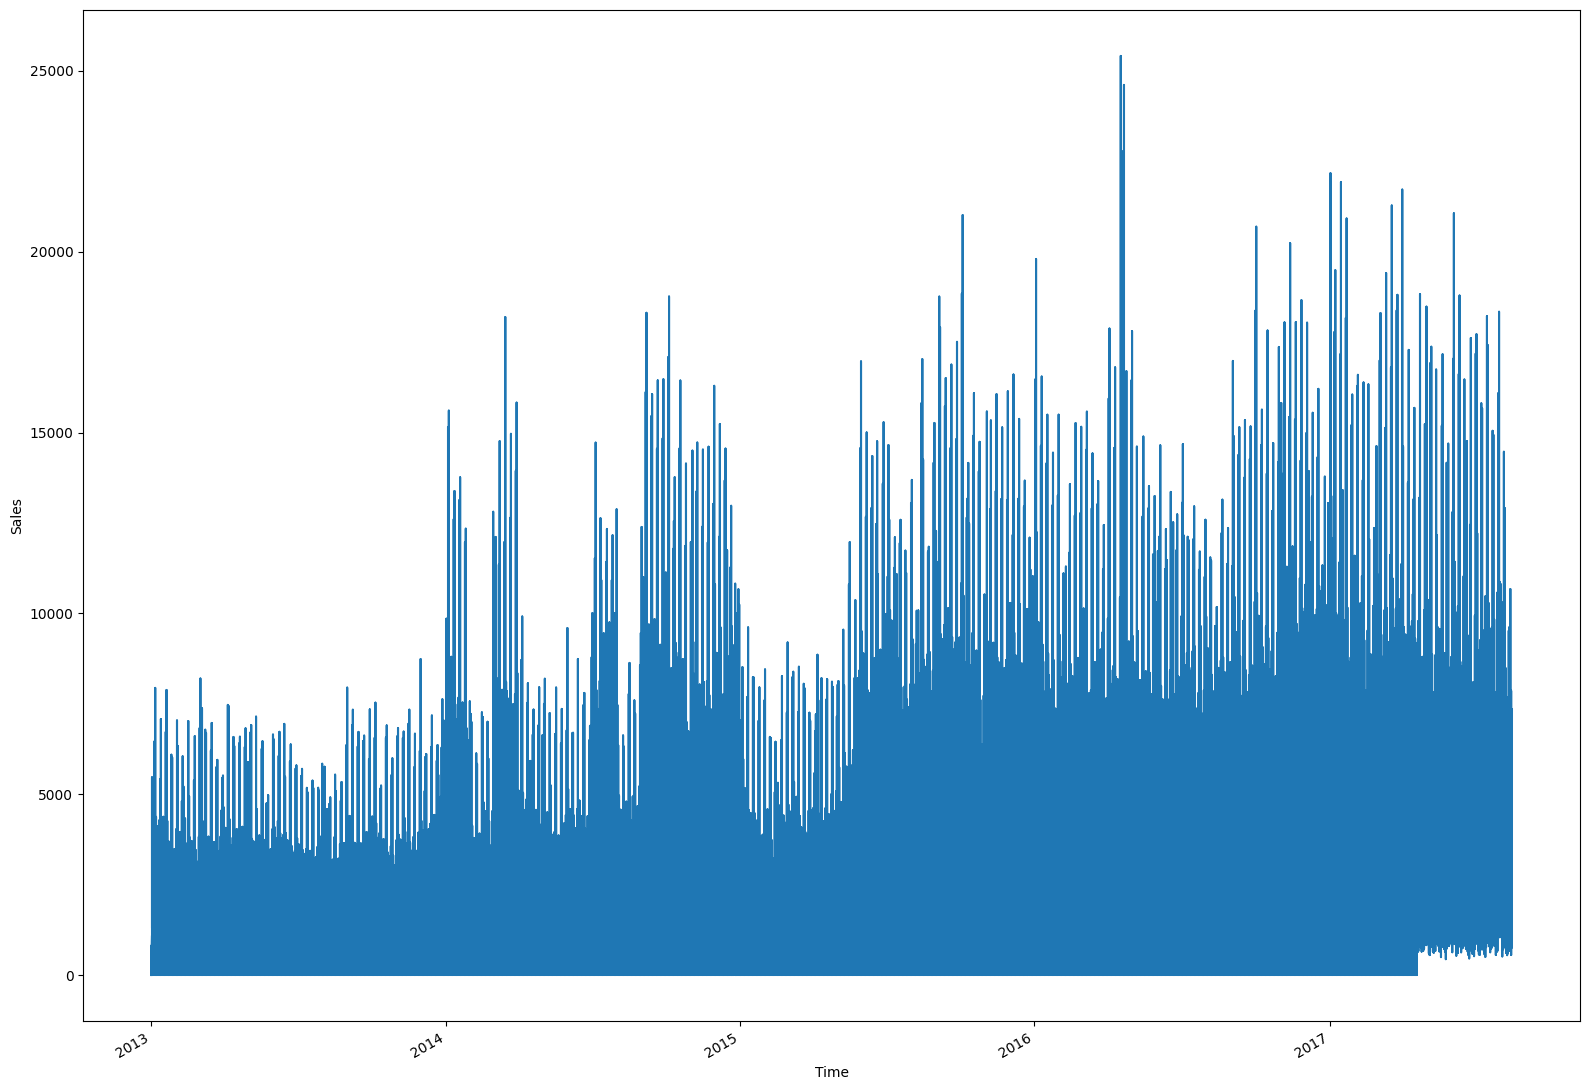

In [11]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(data_unus_train['sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
fig.autofmt_xdate()
plt.tight_layout()

## Predecir cada dato siguiente a partir de una observación previa.

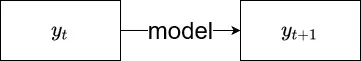

Este es un modelo muy básico porque es dificil que se pueda predecir un dato solo a partir de una observación previa. Mas adelante veremos esta implementación pero con una ventana de observación mayor. Lo importante es que debemos generar una matriz con los datos de entrada y de salida para poder trabajar el esquema tal cual como se ha revisado anteriormente para problemas de clasificación supervisada.

Vamos a adicionar una columna equivalente a la salida que se va a predecir. Para esto se utiliza el método *shift*.

In [12]:
data_unus_train = data_unus_train.copy()
data_unus_train = data_unus_train.fillna(method='bfill')
data_unus_train['y'] = data_unus_train['sales'].shift(-1)

In [13]:
data_unus_train.head()

,sales,store_nbr,y
date,,,
2013-01-01,0.0,1,0.0
2013-01-01,0.0,10,0.0
2013-01-01,0.0,11,0.0
2013-01-01,0.0,12,0.0
2013-01-01,0.0,13,0.0


Con esto podemos implementar un modelo que predice cada observación con la observación previa. En esta construcción se tiene un problema en la última observación que debe ser tratado mas adelante.

In [14]:
data_unus_train.tail()
#test = data_unus_train.drop(data_unus_train.tail(1).index) # Drop last row

,sales,store_nbr,y
date,,,
2017-08-15,4332.0,54,2678.0
2017-08-15,2678.0,6,3999.0
2017-08-15,3999.0,7,3626.0
2017-08-15,3626.0,8,3530.0
2017-08-15,3530.0,9,NaN


No tenemos que dividir el conjunto de datos de test y train porque ya la serie viene tiene los datos por separado

In [15]:
train = data_unus_train[:-104]
test = data_unus_train[-104:]
test = test.fillna(method='bfill')

Vamos a implementar dos modelos de regresión, arboles de decisión y un algoritmos de regresión basado en Gradient Boosting. La predicción la agregamos como una columna adicional en el dataframe.

In [16]:
from sklearn.tree import DecisionTreeRegressor
X_train = train['sales'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['sales'].values.reshape(-1,1)
y_test = test['y'].values.reshape(-1,1)
# Initialize the model
dt_reg = DecisionTreeRegressor(random_state=42)
# Fit the model
dt_reg.fit(X=X_train, y=y_train)
# Make predictions
dt_pred = dt_reg.predict(X_test)
# Assign predictions to a new column in test
test['dt_pred'] = dt_pred

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y=y_train.ravel())
gbr_pred = gbr.predict(X_test)
test['gbr_pred'] = gbr_pred

In [18]:
test.head()

,sales,store_nbr,y,dt_pred,gbr_pred
date,,,,,
2017-08-14,1512.0,13,1440.0,2321.086957,2070.685216
2017-08-14,1440.0,14,1814.0,1576.655172,1997.622194
2017-08-14,1814.0,15,1739.0,1801.882353,2223.573538
2017-08-14,1739.0,16,3047.0,2088.062500,2139.833041
2017-08-14,3047.0,17,1996.0,2232.562500,2829.500638


Con el fin de tener una comparación, vamos a agregar una columna de base o referencia donde la predicción es igual a la entrada:

In [19]:
test_2 = test.copy()
test_2['baseline_pred'] = test_2['sales']
test_2['gbr_pred'] = gbr_pred
test_3 = test_2.copy()
test_3_fill = test_3.fillna(0)
test_3_fill.head()

,sales,store_nbr,y,dt_pred,gbr_pred,baseline_pred
date,,,,,,
2017-08-14,1512.0,13,1440.0,2321.086957,2070.685216,1512.0
2017-08-14,1440.0,14,1814.0,1576.655172,1997.622194,1440.0
2017-08-14,1814.0,15,1739.0,1801.882353,2223.573538,1814.0
2017-08-14,1739.0,16,3047.0,2088.062500,2139.833041,1739.0
2017-08-14,3047.0,17,1996.0,2232.562500,2829.500638,3047.0


A continuación vamos a implementar dos medidas de desempeño:



In [20]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

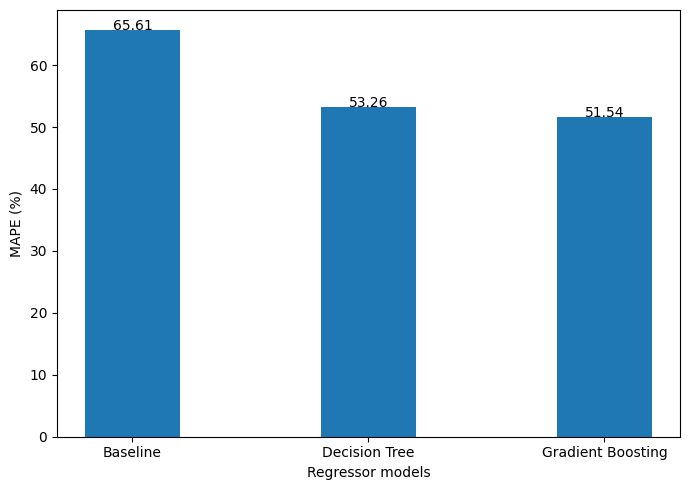

In [21]:
baseline_mape = mape(test_2['y'], test_2['baseline_pred'])
dt_mape = mape(test_2['y'], test_2['dt_pred'])
gbr_mape = mape(test_2['y'], test_2['gbr_pred'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_mape, gbr_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
#ax.set_ylim(0, 0.3)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

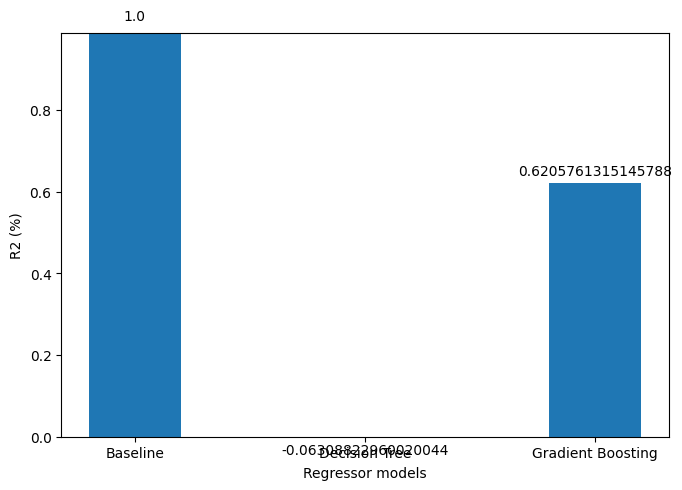

In [22]:
from sklearn.metrics import r2_score
baseline_r2 = r2_score(test_3_fill['sales'], test_3_fill['baseline_pred'])
dt_r2 = r2_score(test_3_fill['sales'], test_3_fill['dt_pred'])
gbr_r2 = r2_score(test_3_fill['sales'], test_3_fill['gbr_pred'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_r2, dt_r2, gbr_r2]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('R2 (%)')
ax.set_ylim(0, 0.99)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

Podemos observar que los modelos no superar la referencia.

##Predicción utilizando una secuencia de valores pasados:

Lo que vamos a realizar a continuación es aumentar la ventana de observación para la entrada del modelo. Es decir, vamos a aumentar el número de características que ingresa al modelo. 

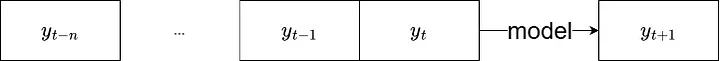

Revisemos la siguiente función que genera una matriz donde cada entrada tiene por ejemplo 5 muestras previas de la serie de tiempo para predecir el dato siguiente:

In [23]:
def window_input(window_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = test_3_fill.copy()
    
    i = 1
    while i < window_length:
        df[f'x_{i}'] = df['sales'].shift(-i)
        i = i + 1
    
    i = window_length
    while i < window_length*2:
        df[f'x_{i}'] = df['sales'].shift(-i)-df['sales']
        i = i + 1
        
    if i == window_length*2:
        df['y'] = df['sales'].shift(-i)
        
    # Drop rows where there is a NaN
    df = df.dropna(axis=0)
        
    return df

In [24]:
new_df = window_input(10, test_3_fill)

In [25]:
new_df.head(10)

,sales,store_nbr,y,dt_pred,gbr_pred,baseline_pred,x_1,x_2,x_3,x_4,...,x_10,x_11,x_12,x_13,x_14,x_15,x_16,x_17,x_18,x_19
date,,,,,,,,,,,,,,,,,,,,,
2017-08-14,1512.0,13,3948.0,2321.086957,2070.685216,1512.0,1440.0,1814.0,1739.0,3047.0,...,595.0,-202.0,1594.0,678.0,-959.0,1869.0,1579.0,1164.0,6347.0,-337.0
2017-08-14,1440.0,14,1009.0,1576.655172,1997.622194,1440.0,1814.0,1739.0,3047.0,1996.0,...,-130.0,1666.0,750.0,-887.0,1941.0,1651.0,1236.0,6419.0,-265.0,2508.0
2017-08-14,1814.0,15,2405.0,1801.882353,2223.573538,1814.0,1739.0,3047.0,1996.0,2627.0,...,1292.0,376.0,-1261.0,1567.0,1277.0,862.0,6045.0,-639.0,2134.0,-805.0
2017-08-14,1739.0,16,2794.0,2088.062500,2139.833041,1739.0,3047.0,1996.0,2627.0,2559.0,...,451.0,-1186.0,1642.0,1352.0,937.0,6120.0,-564.0,2209.0,-730.0,666.0
2017-08-14,3047.0,17,1294.0,2232.562500,2829.500638,3047.0,1996.0,2627.0,2559.0,4246.0,...,-2494.0,334.0,44.0,-371.0,4812.0,-1872.0,901.0,-2038.0,-642.0,-253.0
2017-08-14,1996.0,18,3104.0,2375.954545,2292.979247,1996.0,2627.0,2559.0,4246.0,3493.0,...,1385.0,1095.0,680.0,5863.0,-821.0,1952.0,-987.0,409.0,798.0,-702.0
2017-08-14,2627.0,19,2600.0,2076.666667,2541.925750,2627.0,2559.0,4246.0,3493.0,2107.0,...,464.0,49.0,5232.0,-1452.0,1321.0,-1618.0,-222.0,167.0,-1333.0,477.0
2017-08-14,2559.0,2,1992.0,2301.833333,2541.925750,2559.0,4246.0,3493.0,2107.0,1310.0,...,117.0,5300.0,-1384.0,1389.0,-1550.0,-154.0,235.0,-1265.0,545.0,41.0
2017-08-14,4246.0,20,4419.0,4281.500000,3755.193475,4246.0,3493.0,2107.0,1310.0,3106.0,...,3613.0,-3071.0,-298.0,-3237.0,-1841.0,-1452.0,-2952.0,-1142.0,-1646.0,-2254.0


A continuación extraemos la variables de entrada y la salida para entrenar el modelo y separamos entre un conjunto de test y de entrenamiento:

In [26]:
from sklearn.model_selection import train_test_split

X = new_df.drop('y',axis=1).values
y = new_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

En este caso como predictor de referencia vamos a utilizar un modelo donde el dato futuro se predice como la media de los datos observados.

In [27]:
baseline_pred = []

for row in X_test:
    baseline_pred.append(np.mean(row))

In [28]:
gbr_5 = GradientBoostingRegressor(random_state=42)

gbr_5.fit(X_train, y_train.ravel())

gbr_5_pred = gbr_5.predict(X_test)

Revisemos la métricas de desempeño:

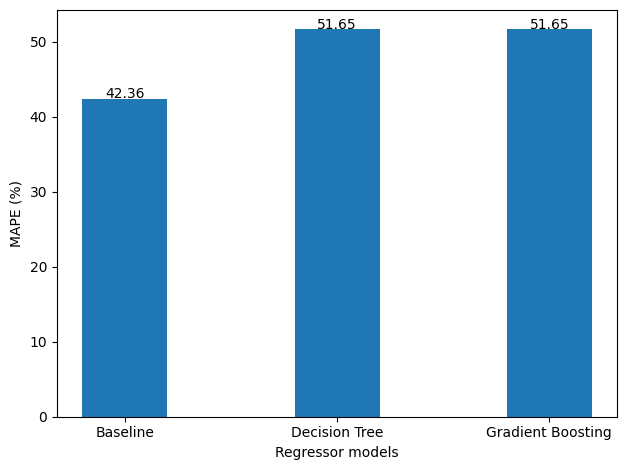

In [29]:
baseline_mape = mape(y_test, baseline_pred)
dt_5_mape = mape(y_test, gbr_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_5_mape, gbr_5_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
#ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

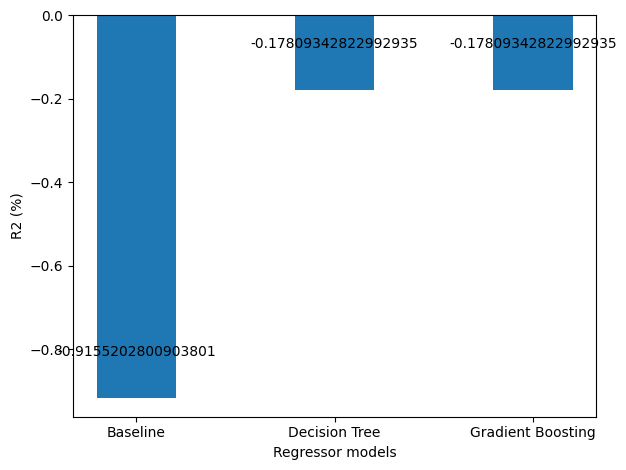

In [30]:
baseline_r2 = r2_score(y_test, baseline_pred)
dt_5_r2 = r2_score(y_test, gbr_5_pred)
gbr_5_r2 = r2_score(y_test, gbr_5_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_r2, dt_5_r2, gbr_5_r2]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('R2 (%)')
#ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

Observemos que todavia es desempeño no supera el predictor de referencia. Lo que vamos a realizar a continuación es aumentar la ventana e igualmente aumentar la ventana de predicción. En este tipo de aplicaciones la ventana de observación puede ser considerado un hiperparámetro y debe ser ajustado.

A continuación entrenamos los modelos:


In [31]:
dt_reg_5 = DecisionTreeRegressor(random_state=42)

dt_reg_5.fit(X_train, y_train)

dt_reg_5_pred = dt_reg_5.predict(X_test)

# Análisis de la segunda tienda

In [32]:
data_duo_train = pd.DataFrame()
data_duo_train['date'] = pd.to_datetime(beauty_data_train['date'])
data_duo_train['sales'] = beauty_data_train['sales']
data_duo_train.loc[beauty_data_train['store_nbr'] == '2']
data_duo_train.set_index('date', inplace=True)
data_duo_train.head()

,sales
date,
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0


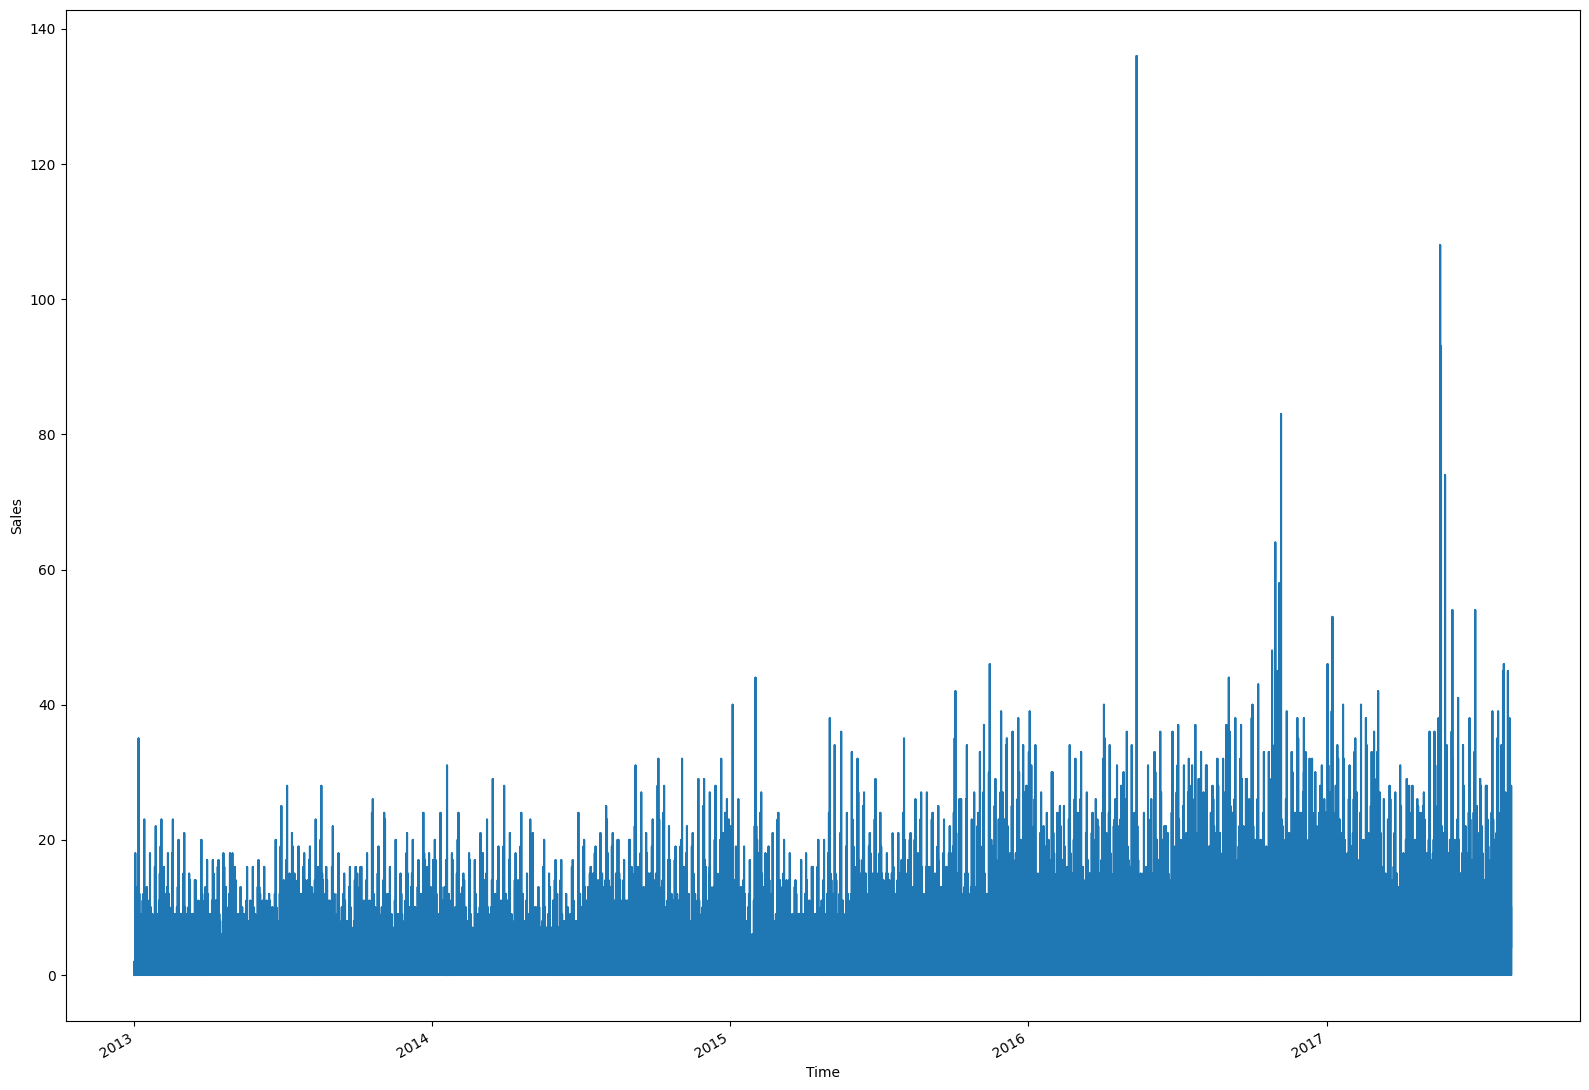

In [33]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(data_duo_train['sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
fig.autofmt_xdate()
plt.tight_layout()

Observemos que en una serie de tiempo tenemos los indices en formato de fecha y la variable del store bnr. Si queremos implementar un algoritmo de regresión basado en aprendizaje supervisado, necesitamos tener además de los datos de entrada un vector de etiquetas o datos de salida (y). Vamos a ver varias alternativas:

## Predecir cada dato siguiente a partir de una observación previa.

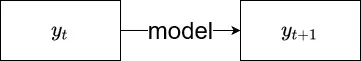

Este es un modelo muy básico porque es dificil que se pueda predecir un dato solo a partir de una observación previa. Mas adelante veremos esta implementación pero con una ventana de observación mayor. Lo importante es que debemos generar una matriz con los datos de entrada y de salida para poder trabajar el esquema tal cual como se ha revisado anteriormente para problemas de clasificación supervisada.

Vamos a adicionar una columna equivalente a la salida que se va a predecir. Para esto se utiliza el método *shift*.

In [34]:
data_duo_train = data_duo_train.copy()
data_duo_train = data_duo_train.fillna(0)
data_duo_train['y'] = data_duo_train['sales'].shift(-1)
data_duo_train.head()

,sales,y
date,,
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0


In [35]:
train = data_duo_train[:-104]
test = data_duo_train[-104:]

In [36]:
test

,sales,y
date,,
2017-08-14,5.0,2.0
2017-08-14,2.0,3.0
2017-08-14,3.0,0.0
2017-08-14,0.0,3.0
2017-08-14,3.0,2.0
...,...,...
2017-08-15,0.0,6.0
2017-08-15,6.0,11.0
2017-08-15,11.0,8.0


In [37]:
test = data_duo_train.fillna(0)

Con esto podemos implementar un modelo que predice cada observación con la observación previa. En esta construcción se tiene un problema en la última observación que debe ser tratado mas adelante.

Vamos a implementar dos modelos de regresión, arboles de decisión y un algoritmos de regresión basado en Gradient Boosting. La predicción la agregamos como una columna adicional en el dataframe.

In [38]:
from sklearn.tree import DecisionTreeRegressor
X_train = train['sales'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['sales'].values.reshape(-1,1)
y_test = test['y'].values.reshape(-1,1)
# Initialize the model
dt_reg = DecisionTreeRegressor(random_state=42)
# Fit the model
dt_reg.fit(X=X_train, y=y_train)
# Make predictions
dt_pred = dt_reg.predict(X_test)
# Assign predictions to a new column in test
test['dt_pred'] = dt_pred

In [39]:
test

,sales,y,dt_pred
date,,,
2013-01-01,0.0,0.0,2.414636
2013-01-01,0.0,0.0,2.414636
2013-01-01,0.0,0.0,2.414636
2013-01-01,0.0,0.0,2.414636
2013-01-01,0.0,0.0,2.414636
...,...,...,...
2017-08-15,0.0,6.0,2.414636
2017-08-15,6.0,11.0,4.237407
2017-08-15,11.0,8.0,6.539634


In [40]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y=y_train.ravel())
gbr_pred = gbr.predict(X_test)
test['gbr_pred'] = gbr_pred

In [41]:
test

,sales,y,dt_pred,gbr_pred
date,,,,
2013-01-01,0.0,0.0,2.414636,2.419300
2013-01-01,0.0,0.0,2.414636,2.419300
2013-01-01,0.0,0.0,2.414636,2.419300
2013-01-01,0.0,0.0,2.414636,2.419300
2013-01-01,0.0,0.0,2.414636,2.419300
...,...,...,...,...
2017-08-15,0.0,6.0,2.414636,2.419300
2017-08-15,6.0,11.0,4.237407,4.235582
2017-08-15,11.0,8.0,6.539634,6.533022


Con el fin de tener una comparación, vamos a agregar una columna de base o referencia donde la predicción es igual a la entrada:

In [42]:
test_3 = test.copy()
test_3['baseline_pred'] = test_3['sales']

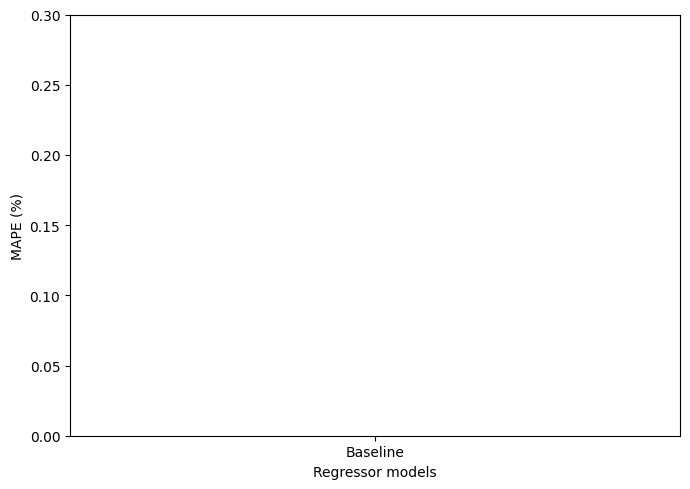

In [43]:
baseline_mape = mape(test_3['y'], test_3['baseline_pred'])
dt_mape = mape(test_3['y'], test_3['dt_pred'])
gbr_mape = mape(test['y'], test['gbr_pred'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_mape, gbr_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 0.3)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

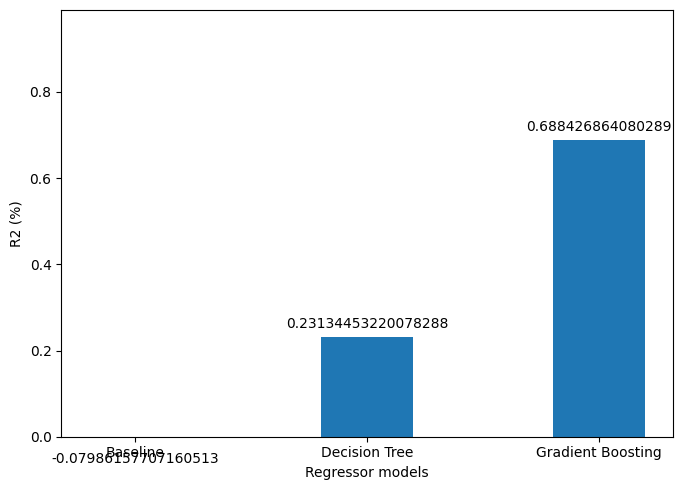

In [44]:
from sklearn.metrics import r2_score
baseline_r2 = r2_score(test_3['y'], test_3['baseline_pred'])
dt_r2 = r2_score(test_3['y'], test_3['dt_pred'])
gbr_r2 = r2_score(test_3['sales'], test_3['gbr_pred'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_r2, dt_r2, gbr_r2]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('R2 (%)')
ax.set_ylim(0, 0.99)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

##Predicción utilizando una secuencia de valores pasados:

In [45]:
new_df = window_input(10, test_3)

In [46]:
from sklearn.model_selection import train_test_split

X = new_df.drop('y',axis=1).values
y = new_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [47]:
baseline_pred = []

for row in X_test:
    baseline_pred.append(np.mean(row))

In [48]:
gbr_5 = GradientBoostingRegressor(random_state=42)

gbr_5.fit(X_train, y_train.ravel())

gbr_5_pred = gbr_5.predict(X_test)

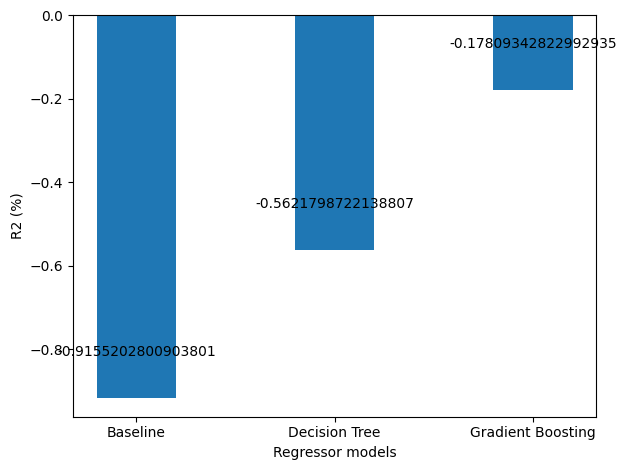

In [49]:
baseline_r2 = r2_score(y_test, baseline_pred)
dt_5_r2 = r2_score(y_test, dt_reg_5_pred)
gbr_5_r2 = r2_score(y_test, gbr_5_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_r2, dt_5_r2, gbr_5_r2]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('R2 (%)')
#ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

# Análisis de la tercer tienda

In [65]:
data_tris = pd.DataFrame()
data_tris['date'] = pd.to_datetime(produce['date'])
data_tris['sales'] = produce['sales']
data_tris.loc[produce['store_nbr'] == '53']
data_tris.set_index('date', inplace=True)
data_tris.head()

,sales
date,
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0
2013-01-01,0.0


Observemos que en una serie de tiempo tenemos los indices en formato de fecha y la variable del store bnr. Si queremos implementar un algoritmo de regresión basado en aprendizaje supervisado, necesitamos tener además de los datos de entrada un vector de etiquetas o datos de salida (y). Vamos a ver varias alternativas:

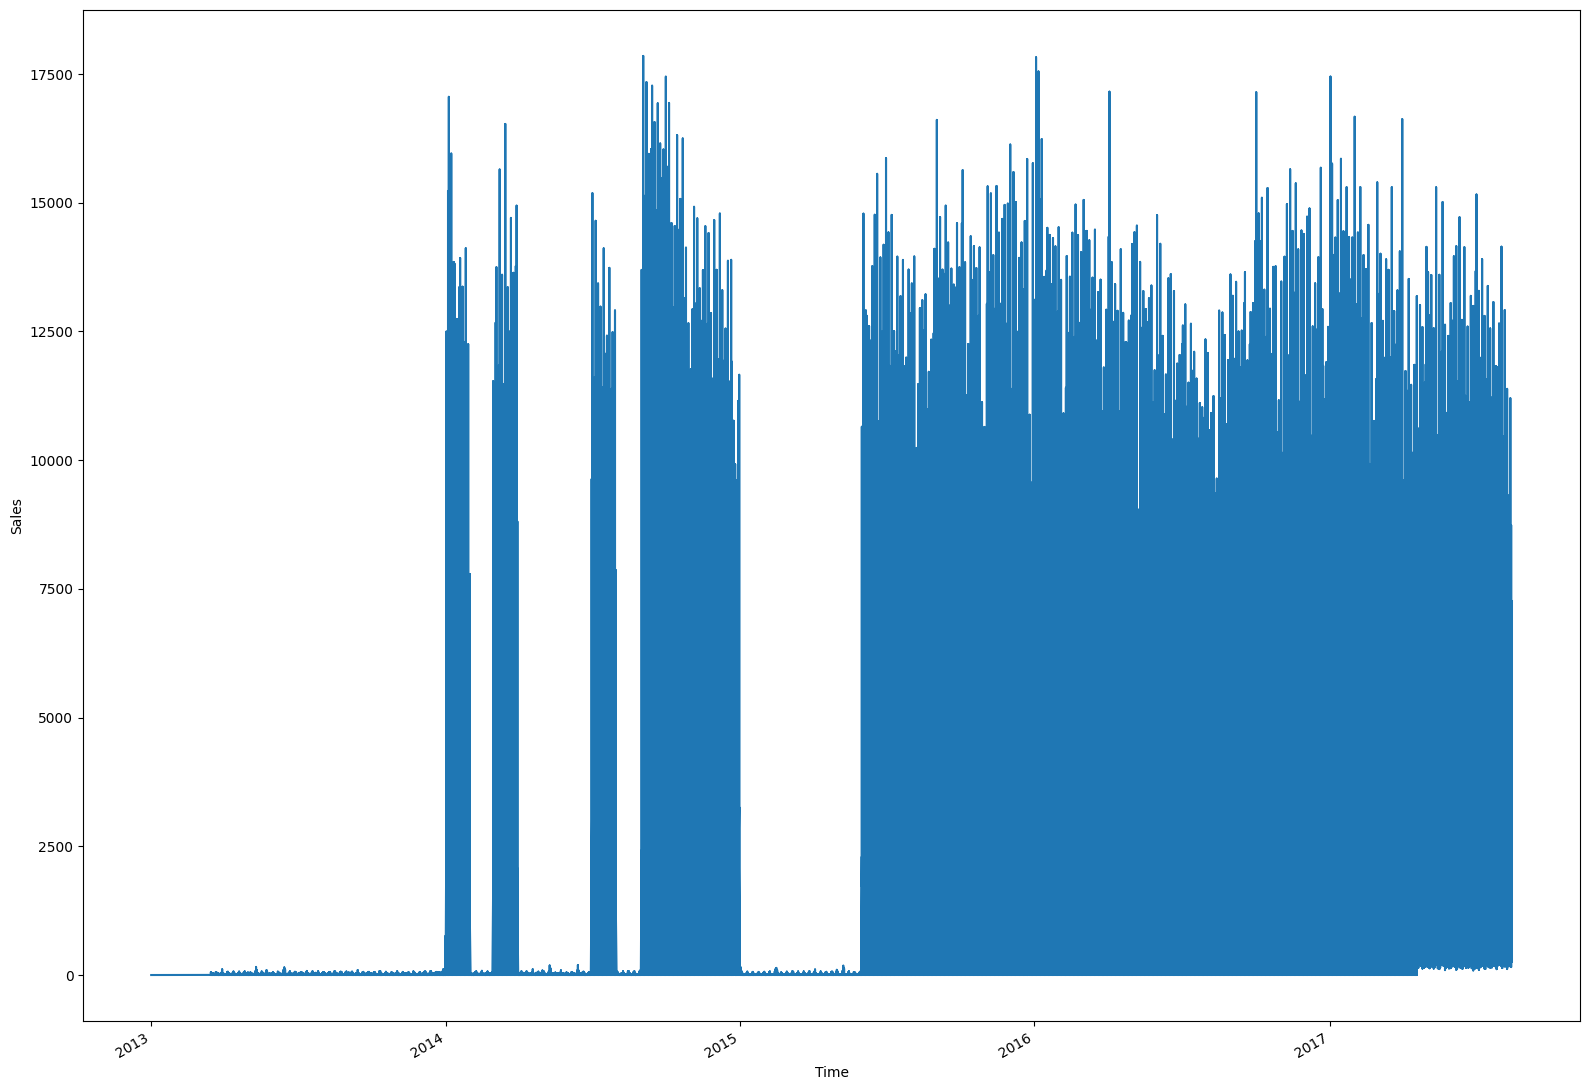

In [66]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(data_tris['sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Sales')
fig.autofmt_xdate()
plt.tight_layout()

## Predecir cada dato siguiente a partir de una observación previa.

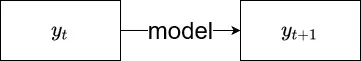

Este es un modelo muy básico porque es dificil que se pueda predecir un dato solo a partir de una observación previa. Mas adelante veremos esta implementación pero con una ventana de observación mayor. Lo importante es que debemos generar una matriz con los datos de entrada y de salida para poder trabajar el esquema tal cual como se ha revisado anteriormente para problemas de clasificación supervisada.

Vamos a adicionar una columna equivalente a la salida que se va a predecir. Para esto se utiliza el método *shift*.

In [67]:
data_tris_train = data_tris.copy()
data_tris_train = data_tris_train.fillna(0)
data_tris_train['y'] = data_tris_train['sales'].shift(-1)
data_tris_train.head()

,sales,y
date,,
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0


Con esto podemos implementar un modelo que predice cada observación con la observación previa. En esta construcción se tiene un problema en la última observación que debe ser tratado mas adelante.

In [70]:
train = data_tris_train[:-104]
test = data_tris_train[-104:]

In [71]:
data_tris_train.tail()
data_tris_train = data_tris_train.fillna(method='bfill')
test = data_tris_train.drop(data_unus_train.tail(1).index) # Drop last row
test.head()

,sales,y
date,,
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0
2013-01-01,0.0,0.0


Con esto podemos implementar un modelo que predice cada observación con la observación previa. En esta construcción se tiene un problema en la última observación que debe ser tratado mas adelante.

Vamos a implementar dos modelos de regresión, arboles de decisión y un algoritmos de regresión basado en Gradient Boosting. La predicción la agregamos como una columna adicional en el dataframe.

In [72]:
from sklearn.tree import DecisionTreeRegressor
X_train = train['sales'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['sales'].values.reshape(-1,1)
y_test = test['y'].values.reshape(-1,1)
# Initialize the model
dt_reg = DecisionTreeRegressor(random_state=42)
# Fit the model
dt_reg.fit(X=X_train, y=y_train)
# Make predictions
dt_pred = dt_reg.predict(X_test)
# Assign predictions to a new column in test
test['dt_pred'] = dt_pred

In [73]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train, y=y_train.ravel())
gbr_pred = gbr.predict(X_test)
test['gbr_pred'] = gbr_pred

Con el fin de tener una comparación, vamos a agregar una columna de base o referencia donde la predicción es igual a la entrada:

In [75]:
test = test.copy()
test['baseline_pred'] = test['sales']

In [76]:
test

,sales,y,dt_pred,gbr_pred,baseline_pred
date,,,,,
2013-01-01,0.000,0.000,164.184394,165.817932,0.000
2013-01-01,0.000,0.000,164.184394,165.817932,0.000
2013-01-01,0.000,0.000,164.184394,165.817932,0.000
2013-01-01,0.000,0.000,164.184394,165.817932,0.000
2013-01-01,0.000,0.000,164.184394,165.817932,0.000
...,...,...,...,...,...
2017-08-14,585.615,2332.902,11159.523000,2523.423081,585.615
2017-08-14,2332.902,5838.443,3459.569000,2416.894276,2332.902
2017-08-14,5838.443,4417.428,5165.926000,2545.186598,5838.443


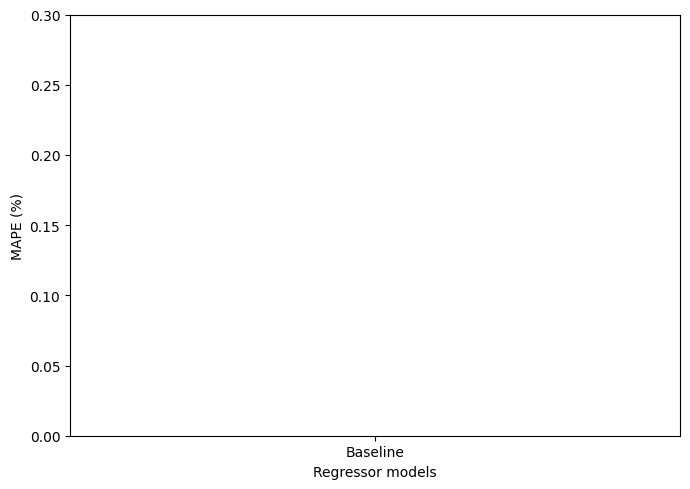

In [78]:
baseline_mape = mape(test['y'], test['baseline_pred'])
dt_mape = mape(test['y'], test['dt_pred'])
gbr_mape = mape(test['sales'], test['gbr_pred'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_mape, gbr_mape]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 0.3)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

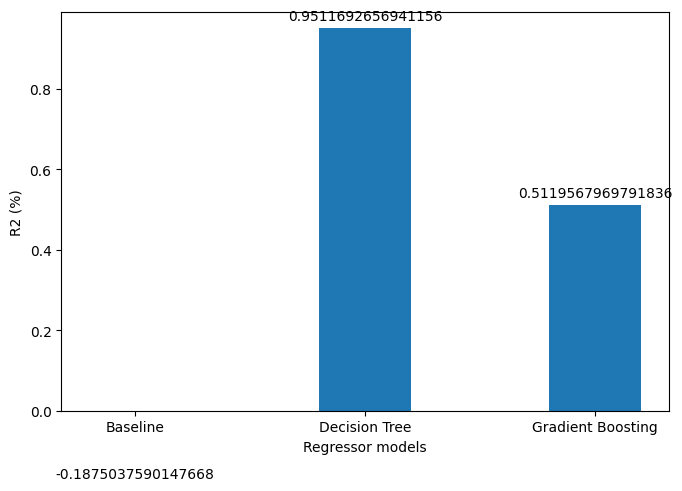

In [80]:
from sklearn.metrics import r2_score
baseline_r2 = r2_score(test['y'], test['baseline_pred'])
dt_r2 = r2_score(test['y'], test['dt_pred'])
gbr_r2 = r2_score(test['sales'], test['gbr_pred'])
# Generate bar plot
fig, ax = plt.subplots(figsize=(7, 5))
x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_r2, dt_r2, gbr_r2]
ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('R2 (%)')
ax.set_ylim(0, 0.99)
for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()

Revisamos las métricas

<ipython-input-20-4f8c6fe9f5d7>:2: RuntimeWarning: divide by zero encountered in true_divide
  return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)


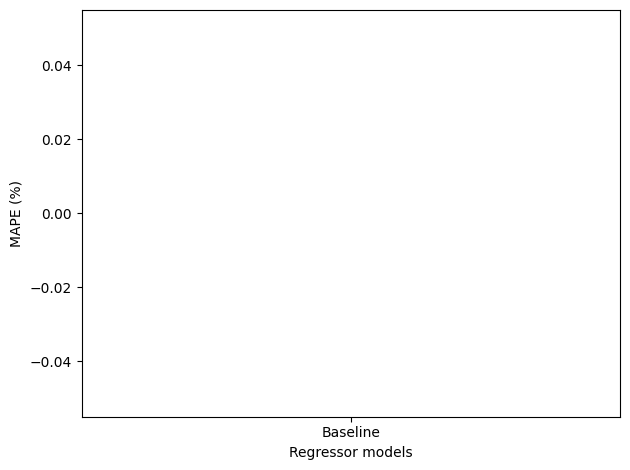

In [81]:
baseline_mape = mape(y_test, baseline_pred)
dt_5_mape = mape(y_test, dt_reg_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_5_mape, gbr_5_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
#ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

##Predicción utilizando una secuencia de valores pasados:

In [83]:
new_df = window_input(10, data_tris_train)

In [84]:
from sklearn.model_selection import train_test_split

X = new_df.drop('y',axis=1).values
y = new_df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

In [85]:
baseline_pred = []

for row in X_test:
    baseline_pred.append(np.mean(row))

In [86]:
gbr_5 = GradientBoostingRegressor(random_state=42)

gbr_5.fit(X_train, y_train.ravel())

gbr_5_pred = gbr_5.predict(X_test)

Revisamos las métricas

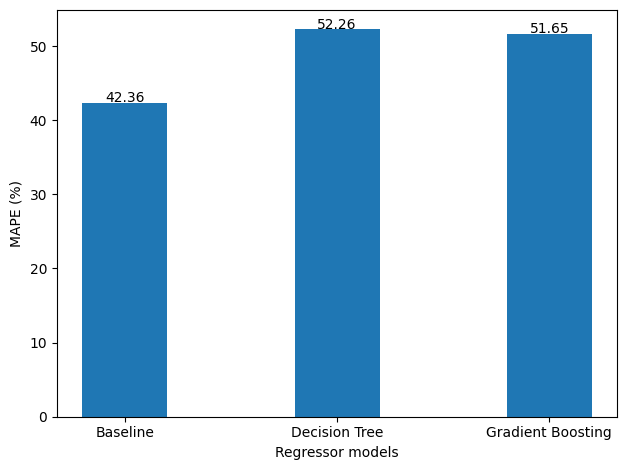

In [87]:
baseline_mape = mape(y_test, baseline_pred)
dt_5_mape = mape(y_test, dt_reg_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_5_mape, gbr_5_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
#ax.set_ylim(0, 5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()